In [1]:
import os

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [4]:
os.getcwd()

'C:\\Users\\suman'

In [5]:
os.chdir('F:\\IITB\\github_project\\Sales_Forecast')

In [6]:
os.getcwd()

'F:\\IITB\\github_project\\Sales_Forecast'

In [7]:
store_sales = pd.read_csv('train.csv')
store_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


check for null values in the data set

In [8]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


Dropping store and item column

In [9]:
store_sales = store_sales.drop(['store','item'],axis = 1)

In [10]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


converting date from object datatype to datetime datatype

In [11]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [12]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


converting date to a Month period, and then sum the number of items in each month

In [13]:
store_sales['date'] = store_sales['date'].dt.to_period('M')
monthly_sales = store_sales.groupby('date').agg({'sales':'sum'}).reset_index()

In [14]:
monthly_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype    
---  ------  --------------  -----    
 0   date    60 non-null     period[M]
 1   sales   60 non-null     int64    
dtypes: int64(1), period[M](1)
memory usage: 1.1 KB


convert the resulting date column to timestamp datatype

In [15]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [16]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


Visualize

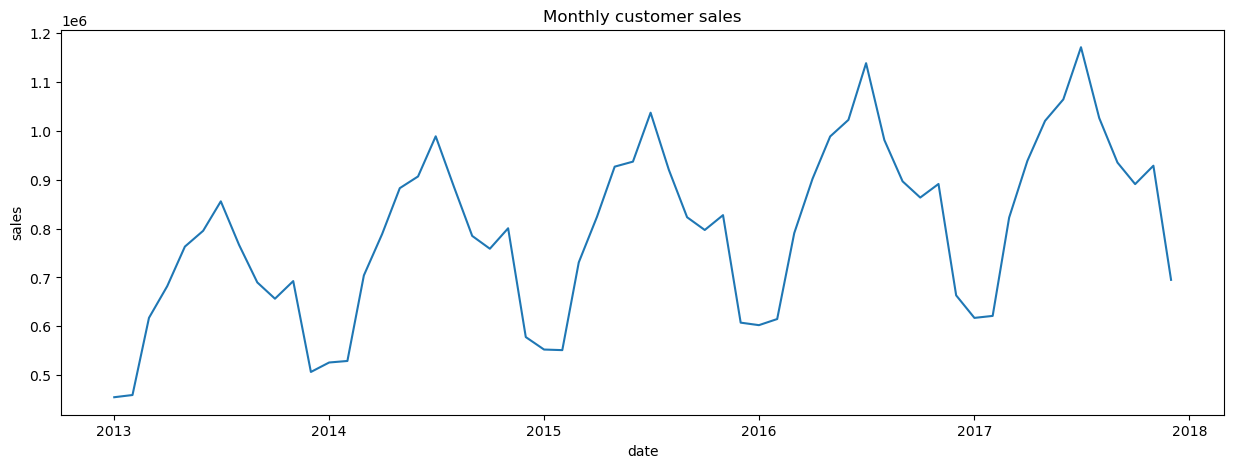

In [17]:
plt.figure(figsize = (15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Monthly customer sales')
plt.show()

call the difference on the sales columns to make the sales data stationary

In [18]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


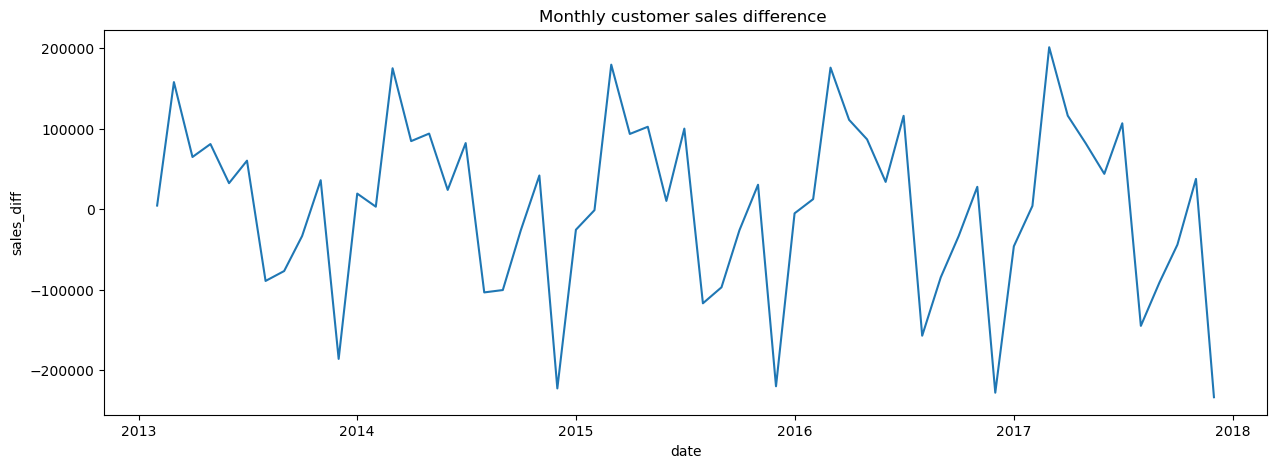

In [19]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel('date')
plt.ylabel('sales_diff')
plt.title('Monthly customer sales difference ')
plt.show()

In [21]:
supervised_data = monthly_sales.drop(['date','sales'],axis = 1)


preparing the supervised data

In [22]:
for i in range(1,13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop = True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


split the data into Train and Test

In [23]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print('Train Data shape: ', train_data.shape)
print('Test Data Shape: ', test_data.shape)

Train Data shape:  (35, 13)
Test Data Shape:  (12, 13)


scale the value

In [24]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

in supervised 1st column always acts as a output and remaining column as input

In [25]:
x_train,y_train = train_data[:,1:], train_data[:,0:1]
x_test,y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)

x_train shape:  (35, 12)
y_train shape:  (35,)
x_test shape:  (12, 12)
y_test shape:  (12,)


Make prediction data frame to merge the predicted sales prices of all trained algs

In [26]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)



In [27]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


To create the linear regression model, and predicted output

In [28]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pre = lr_model.predict(x_test)

In [29]:
lr_pre = lr_pre.reshape(-1,1)
# This is aset matrix - contains the input features of the test data, and also the predicted output
lr_pre_test_set = np.concatenate([lr_pre,x_test],axis =1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [30]:
result_list = []
for index in range(0, len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list,name='Linear Prediction')
predict_df = predict_df.merge(lr_pre_series, left_index = True, right_index = True)

In [31]:
# print(predict_df)

lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
print('Linear Regression MSE: ', lr_mse)
print('Linear Regression MAE: ', lr_mae)
print('Linear Regression R2: ', lr_r2)


Linear Regression MSE:  16221.27238541689
Linear Regression MAE:  12433.184266490784
Linear Regression R2:  0.9906152516380969


Visualization of the prediction against the actual sales

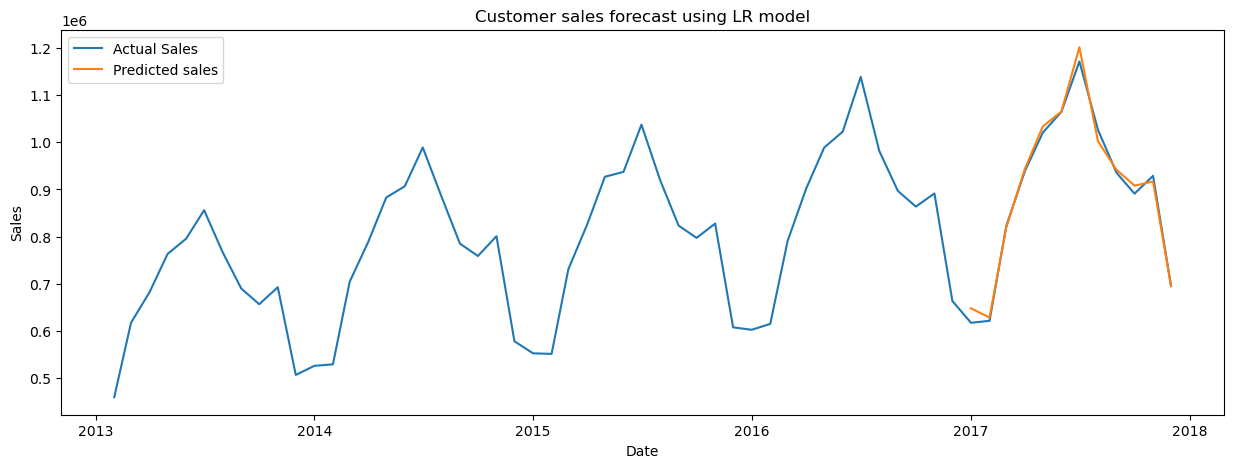

In [33]:
plt.figure(figsize = (15,5))
# Actual sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])
# Predicted sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title('Customer sales forecast using LR model')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(['Actual Sales','Predicted sales'])
plt.show()